In [3]:
%matplotlib inline

In [4]:
#import gym modules
import gym
import gym_ple
from gym.wrappers import Monitor
import pygame

couldn't import doomish
Couldn't import doom


In [5]:
# import pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T

from torch.autograd import Variable

In [6]:
# import time to slow down rendering speed
import time
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from itertools import count

In [7]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor


In [9]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [10]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(32*5*5, 5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        #print("1", x.shape)
        x = F.relu(self.bn2(self.conv2(x)))
        #print("2", x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
        #print("3", x.shape)
#        xx = x.view(1, -1)
#        print("final", x.shape)
 #       print(xx.shape)
        return self.head(x.view(x.size(0), -1))

In [11]:
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(100000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
#         print("not random")
        return model(Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
#         print("random")
        return LongTensor([[random.randrange(2)]])


episode_durations = []
episode_rewards = []
epi_food_obtained = []


def plot_durations():
    plt.figure(2, figsize = (15,5))
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.subplot(1,3,1)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), 'r')
        
        
    plt.subplot(1,3,2)
    plt.title('Total Reward vs episodes')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(range(len(episode_rewards)), episode_rewards, 'r')
    
    plt.subplot(1,3,3)
    plt.title('# Food obtained')
    plt.xlabel("Episode")
    plt.ylabel("# Food obtained")
    plt.plot(range(len(epi_food_obtained)), epi_food_obtained, 'r')
    plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         display.clear_output(wait=True)
#         display.display(plt.gcf())


In [12]:
last_sync = 0


def optimize_model():
    global last_sync
    from IPython.core.debugger import Tracer
    
    # if population of the replay memory is not enough, don't do anything
    if len(memory) < BATCH_SIZE:
        return
    # uncomment to enable debugger
    # Tracer()()
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))

    # We don't want to backprop through the expected action values and volatile
    # will save us on temporarily changing the model parameters'
    # requires_grad to False!
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [13]:
params = list(model.parameters())
params

[Parameter containing:
 (0 ,0 ,.,.) = 
   0.0082  0.0308 -0.0063 -0.0582 -0.1069
  -0.0486  0.0739  0.1019 -0.0378 -0.0151
   0.0712  0.0117  0.0087  0.0658  0.0219
  -0.0599 -0.0121 -0.0056  0.1034  0.0684
   0.0732  0.0347 -0.1145  0.0491 -0.0704
 
 (0 ,1 ,.,.) = 
   0.0850  0.0374 -0.0389 -0.0576 -0.0811
   0.0177 -0.0091  0.0190 -0.0084  0.1076
  -0.1153  0.0844 -0.0417  0.0339 -0.0419
  -0.1037  0.0527 -0.0236  0.0224 -0.0582
   0.0165  0.0863  0.0432 -0.0378 -0.0703
 
 (0 ,2 ,.,.) = 
  -0.1150 -0.1137  0.0330 -0.0967  0.1103
  -0.0294  0.1019  0.1067 -0.0593 -0.0802
   0.0344  0.0415 -0.0062 -0.0752  0.0761
  -0.0747 -0.0394  0.0344 -0.0674  0.0904
   0.1016 -0.0375 -0.0089  0.0787 -0.0543
      ⋮ 
 
 (1 ,0 ,.,.) = 
   0.0501 -0.0642  0.0864 -0.0762  0.0857
  -0.0440 -0.0433  0.0840  0.0746 -0.0764
  -0.0701  0.0908 -0.0383 -0.0187 -0.0088
   0.0141  0.1007 -0.0300  0.0010 -0.1131
  -0.0750  0.0674 -0.1129 -0.0165  0.0666
 
 (1 ,1 ,.,.) = 
  -0.1008 -0.0745  0.0643  0.0238 -0.013

In [14]:
len(memory.memory)

0

In [15]:
def to_grayscale(img):
    """
    turns an image into a grayscale image
    """
    return np.mean(img, axis=2).astype(np.uint8)

In [16]:
def downsample(img):
    """
    downsamples an image by taking everyone second pixel
    """
    return img[::2, ::2]

In [17]:
def preprocess(img):
    """
    preprocesses the image with grayscale and downsampling
    """
    return to_grayscale(downsample(img))

In [18]:
def transform_reward(reward):
    """
    returns the sign of the reward, so that the learning agent can be used in multiple games
    """
    return np.sign(reward)

In [19]:
from PIL import Image
resize = T.Compose([T.ToPILImage(),
                    T.ToTensor()])

def get_screen(frame):
#     frame = torch.from_numpy(preprocess(frame)).unsqueeze(0)
#    screen = preprocess(frame)
    screen = frame.transpose(
         (2, 0, 1))  # transpose into torch order (CHW)
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).type(Tensor)

In [48]:
# create gym env
env = gym.make('Snake-v0')
outdir='/tmp/random-agent-results'
env = Monitor(env, directory=outdir, force=True)
env.seed(1234)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
food obtained, now eaten 1 foods
crashed
Running episode #16; episode duration is 13 steps


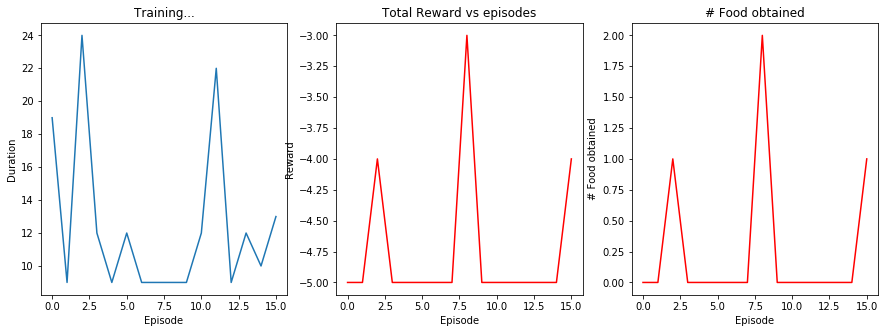

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
food obtained, now eaten 1 foods
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box a

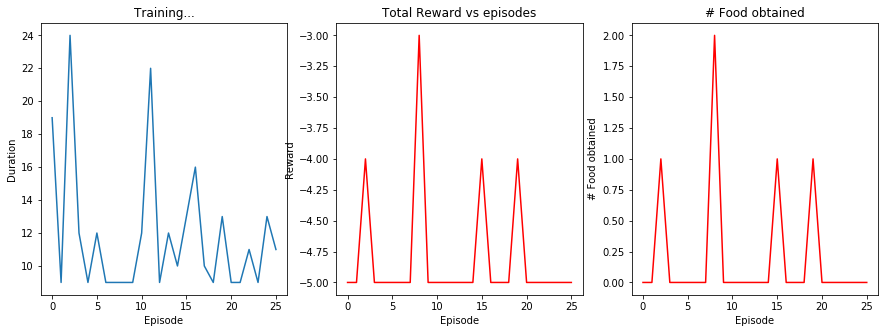

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
food obtained, now eaten 1 foods
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
food obtained, now eaten 1 foo

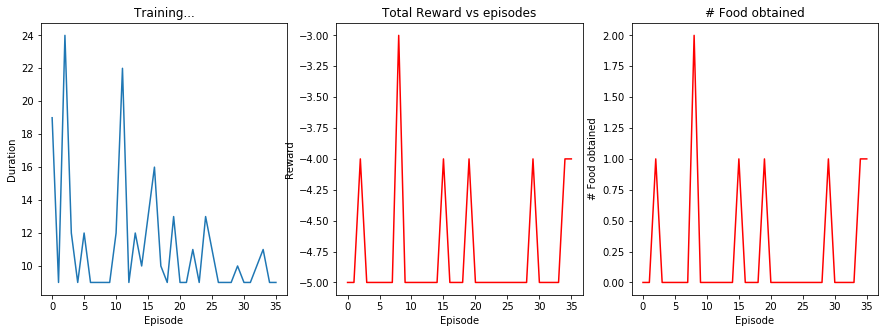

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
food obtained, now eaten 1 foods
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box a

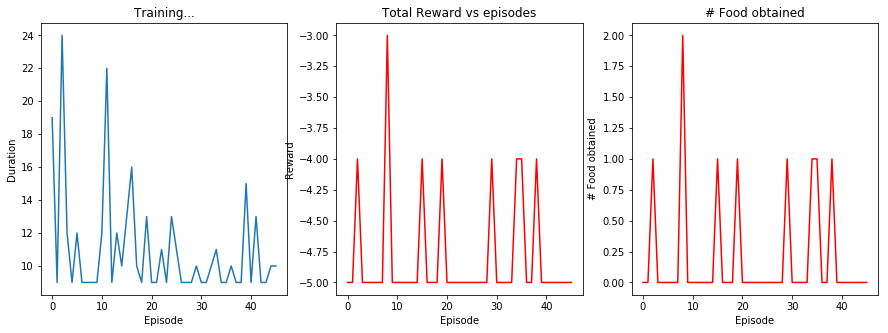

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
food obtained, now eaten 1 foods
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
food obtained, now eaten 1 foods
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
food obtained, now eaten 1 foods
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint

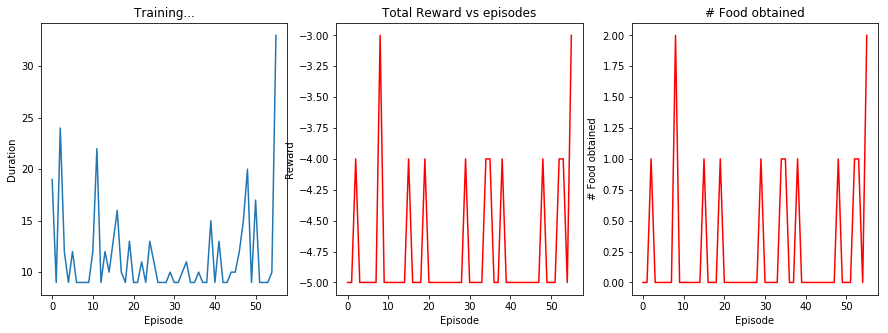

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
food obtained, now eaten 1 foods
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
food obtained, now eaten 1 foods
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
crashed
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtyp

In [49]:
# main
plot_every = 10
print_every = 10
num_episodes = 5000
ministack_n = 4
for i_episode in range(num_episodes):
    # Initialize the environment and state
    # get initial observation
    init_obs = env.reset()
    current_screen = get_screen(init_obs)
    state = current_screen
    current_reward = 0
    food_obtained = 0
    for t in count():
        
        '''
        # Select and perform an action
        action = select_action(state)
        next_obs, reward, done, _ = env.step(action[0, 0])'''
        #print("Initial state ")
        #print(state)
        
        done = False
        ministack_frames = 0
        ministack_f = [state]
        ministack_r = []

        # this is ran at least once
        while not done and ministack_frames < ministack_n:
            # Select and perform an action
            action = select_action(ministack_f[-1])
            next_obs, reward, done, _ = env.step(action[0, 0])
            ministack_f.append(get_screen(next_obs))
            ministack_r.append(reward)
            ministack_frames += 1

        #print("frames in stack {}".format(len(ministack_f)))
        next_obs = ministack_f.pop(-1)
        state = ministack_f[-1]
        
        # perform changes on the ministack data if theres any
        if len(ministack_f) > 1:
            # iterate through ministack
            #print("ministacks ")
            for i, c in enumerate(ministack_f[:-1]) :
                # reduce intensity of earlier frames
                # print("i:{}, ministack_Frames:{}".format(i, len(ministack_f)))
                c = c / 2 ** (len(ministack_f) - i - 1)
                state -= c
                # print("stack number " + str(i))
                # print(c)
        state = torch.clamp(state, 0, 1)
        
        for i,r in enumerate(ministack_r) :
            # replace reward values
            if r == 1:
                food_obtained += 1
                print("food obtained, now eaten %d foods" % food_obtained)
                ministack_r[i] = 1000
            elif r == 0:    
                # give a negative reward for each step taken
                ministack_r[i] = -1
            elif r == -5:
                print('crashed')
                # hits a wall
                ministack_r[i] = -500
                    
        # update obs variable for model
        current_screen = state
        # print("final state")
        # print(current_screen)
        
        # update reward variable for model 
        reward = sum(ministack_r)
        
        # update current total reward
        current_reward += reward
        
        reward = Tensor([reward])
        

        # Observe new state
        last_screen = current_screen
        current_screen = next_obs
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
            

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(current_reward)
            epi_food_obtained.append(food_obtained)
            if i_episode % print_every == 0:
                print("Running episode #%d; episode duration is %d steps" % (len(episode_durations), t+1))
            if i_episode % plot_every == 0:
                plot_durations()
            break

print('Complete')
save_model(model, PATH+'dqn_reward5000.pth')


In [24]:
class Agent(object):
    def __init__(self, action_space):
        self.action_space = action_space

    def random_act(self, observation, reward, done):
        return self.action_space.sample()
    
    # 0 : nothing, 1: left, 2: right
    def fix_act(self):
        return 1


In [36]:
len(memory.memory)

7782

In [ ]:
env = gym.make('Snake-v0')
outdir='/tmp/random-agent-results'
env = Monitor(env, directory=outdir, force=True)
env.seed(1234)
agent = Agent(env.action_space)


In [ ]:
reward = 0
done=False


In [ ]:
ob = env.reset()
done = False
screen_caps = []
rewards = []
while not done: 
    action = agent.fix_act()
    ob, reward, done, _ = env.step(0)
    rewards.append(reward)
    screen_caps.append(ob)

In [ ]:
plt.imshow(screen_caps[0])

In [ ]:
plt.imshow(screen_caps[-1])

In [ ]:
print(ob.shape)

In [27]:
PATH = 'models/'

In [26]:
def save_model(model, path):
    model.float()
    torch.save(model.state_dict(), path)

In [28]:
save_model(model, PATH+'dqn_reward1000.pth')

In [ ]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))

In [ ]:
load_model(model, PATH+'dqn.pth')

In [ ]:
for parameter in model.parameters():
    print(parameter)